In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%%bash
cd /content/drive/MyDrive/optimization_and_ml/labs/lab_08_reinforcement_learning/

# Lab 09 - Reinforcement Learning

In reinforcement learning (RL), an "agent" chooses actions given information about the present state of the system, and is given a reward (a measure of how good the action was). The aim is to maximize the cumulative returned reward over many interactions with the system.

The problem is defined as a series of state transitions consisting of: State --> Action --> New State + reward.

Multiple sequences make up an "episode" consisting of N state transitions.



In this example, we'll look at the Deep Deterministic Policy Gradient (DDPG) algorithm (see paper [here](https://arxiv.org/abs/1509.02971)), for the standard **pendulum problem** (balancing a pendulum upright by applying torque). See problem details here https://www.gymlibrary.dev/environments/classic_control/pendulum/.





DDPG is an example of actor-critic RL where a mapping from observed to actions (i.e. a  "policy" or "actor") and an estimate of the long-term value of taking actions in a given state (i.e. a "critic") are both learned functions parameterized by neural networks. The critic provides the training signal for the actor, and the returned rewards provide the training signal for the critic.




# Set up environment

In [8]:
import os, sys
sys.path.append(os.getcwd())
sys.path.append('/content/drive/MyDrive/optimization_and_ml/labs/lab_08_reinforcement_learning')#replace path as needed

In [9]:
%reset -f
import numpy as np
import json
import time
import pickle as pickle
import matplotlib.pyplot as plt
from IPython.display import clear_output


import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.autograd as autograd

import random
from collections import deque


import gym
from gym import error, spaces, utils
from gym.utils import seeding

from os import path


%matplotlib inline

# Take a look at the DDPGAgent class below:

In [10]:
from ddpg.models import Critic, Actor
from common.exp_replay import ExperienceReplayLog
from common.noise import OUNoise


class DDPGAgent:

    def __init__(self, env, gamma, tau, buffer_maxlen, critic_learning_rate, actor_learning_rate, max_action = 1):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.env = env
        self.obs_dim = env.observation_space.shape[0]
        self.action_dim = env.action_space.shape[0]
        self.noise = OUNoise(env.action_space)
        self.iter = 0.0
        self.noisy = False

        self.max_action= max_action

        #print(self.action_dim)
        #print(self.obs_dim)

        # RL options
        self.env = env
        self.gamma = gamma #discount factor
        self.tau = tau #target network updates

        # Initialize critic and actor networks
        self.critic = Critic(self.obs_dim, self.action_dim).to(self.device)
        self.critic_target = Critic(self.obs_dim, self.action_dim).to(self.device)

        self.actor = Actor(self.obs_dim, self.action_dim,self.max_action).to(self.device)
        self.actor_target = Actor(self.obs_dim, self.action_dim).to(self.device)

        # Copy target network paramters for critic
        for target_param, param in zip(self.critic_target.parameters(), self.critic.parameters()):
            target_param.data.copy_(param.data)

        # Set Optimization algorithms
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=critic_learning_rate)
        self.actor_optimizer  = optim.Adam(self.actor.parameters(), lr=actor_learning_rate)

        self.replay_buffer = ExperienceReplayLog(buffer_maxlen)

    def get_action(self, obs):
        #print('obs;',obs)

        if self.noisy == True:
            state = torch.FloatTensor(obs).unsqueeze(0).to(self.device)
            action = self.actor.forward(state)
            action = action.squeeze(0).cpu().detach().numpy()
            action = self.noise.get_action(action,self.iter)
            self.iter = self.iter+1

        else:
            state = torch.FloatTensor(obs).unsqueeze(0).to(self.device)
            action = self.actor.forward(state)
            action = action.squeeze(0).cpu().detach().numpy()

        return action

    def update(self, batch_size):

        #Batch updates
        states, actions, rewards, next_states, _ = self.replay_buffer.sample(batch_size)
        state_batch, action_batch, reward_batch, next_state_batch, masks = self.replay_buffer.sample(batch_size)
        state_batch = torch.FloatTensor(state_batch).to(self.device)
        action_batch = torch.FloatTensor(action_batch).to(self.device)
        reward_batch = torch.FloatTensor(reward_batch).to(self.device)
        next_state_batch = torch.FloatTensor(next_state_batch).to(self.device)
        masks = torch.FloatTensor(masks).to(self.device)

        # Q info updates
        curr_Q = self.critic.forward(state_batch, action_batch)
        next_actions = self.actor_target.forward(next_state_batch)
        next_Q = self.critic_target.forward(next_state_batch, next_actions.detach())
        expected_Q = reward_batch + self.gamma * next_Q

        # Update Critic network
        q_loss = F.mse_loss(curr_Q, expected_Q.detach())

        self.critic_optimizer.zero_grad()
        q_loss.backward()

        self.critic_optimizer.step()

        # Update Actor network
        policy_loss = -self.critic.forward(state_batch, self.actor.forward(state_batch)).mean()

        self.actor_optimizer.zero_grad()
        policy_loss.backward()
        self.actor_optimizer.step()

        # Update Actor and Critic target networks
        for target_param, param in zip(self.actor_target.parameters(), self.actor.parameters()):
            target_param.data.copy_(param.data * self.tau + target_param.data * (1.0 - self.tau))

        for target_param, param in zip(self.critic_target.parameters(), self.critic.parameters()):
            target_param.data.copy_(param.data * self.tau + target_param.data * (1.0 - self.tau))


<a id='pendulum'></a>

# Pendulum


Take a look at how the Pendulum environment is defined in openAI gym below (this is the standard openAI gym implementation, and we've added additional helper functions for plotting)

In [11]:

class PendulumEnv(gym.Env):
    metadata = {
        'render.modes': ['human', 'rgb_array'],
        'video.frames_per_second': 30
    }

    def __init__(self, g=10.0):
        self.max_speed = 8
        self.max_torque = 2.
        self.dt = .05
        self.g = g
        self.m = 1.
        self.l = 1.
        self.viewer = None

        #define action and observation space
        high = np.array([1., 1., self.max_speed], dtype=np.float32)

        self.action_space = spaces.Box(
            low=-self.max_torque,
            high=self.max_torque, shape=(1,),
            dtype=np.float32
        )
        self.observation_space = spaces.Box(
            low=-high,
            high=high,
            dtype=np.float32
        )

        self.seed()

        #lists for plotting
        self.q1s=[]
        self.costs=[]
        self.reset_ep=[]
        self.plot = True


    def log_results(self,q11, reward, reset_ep_flag  = False):

        '''
        logs the results of a given iteration, for quad inputs, the reward, and whether the episode was resett

        '''

        self.costs.append(reward)
        self.q1s.append(q11)



        if reset_ep_flag == True:
            self.reset_ep.append(1)

        else:
            self.reset_ep.append(0)

    def plot_results(self,):

        '''
        plots the results from the logged values

        '''

        clear_output(wait=True)


        f = plt.figure(figsize=(25,3))
        ax = f.add_subplot(141)
        ax2 = f.add_subplot(142)


        plot_reset = np.where(np.array(self.reset_ep)==1)[0]
        for i in range(0, len(plot_reset)):
            ax.axvline(x=plot_reset[i],alpha=0.1,color='k')
            ax2.axvline(x=plot_reset[i],alpha=0.1,color='k')

        ax.plot(self.q1s,'.')
        ax.set_ylabel('action',fontsize=12)
        ax2.plot(self.costs, 'k.')
        ax2.set_ylabel('reward',fontsize=12)

        ax.set_xlabel('Iteration',fontsize=12)
        ax2.set_xlabel('Iteration',fontsize=12)



        plt.show();

    def reset_plot(self,):

        '''
        resets the logs and the plot

        '''
        self.costs=[]
        self.q1s=[]
        self.reset_ep=[]


    def save_plot(self,name = 'mon_'):

        '''
        saves results from the logged values to a json file

        '''

        run_details = {
            'q1': self.q1s,
            'costs': self.costs,
            'reset_ep': self.reset_ep,
        }

        with open(name + '.json', 'w') as json_file:
            json.dump(run_details, json_file, default = to_serializable)

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def step(self, u):
        th, thdot = self.state  # th := theta

        g = self.g #gravity
        m = self.m #mass
        l = self.l #pendulum length
        dt = self.dt #timestep

        u = np.clip(u, -self.max_torque, self.max_torque)[0]
        self.last_u = u  # for rendering
        costs = angle_normalize(th) ** 2 + .1 * thdot ** 2 + .001 * (u ** 2)

        newthdot = thdot + (-3 * g / (2 * l) * np.sin(th + np.pi) + 3. / (m * l ** 2) * u) * dt
        newth = th + newthdot * dt
        newthdot = np.clip(newthdot, -self.max_speed, self.max_speed)



        self.log_results(u, -costs, reset_ep_flag = False)


        if self.plot == True:
            self.plot_results()

        else:
            clear_output()

        self.state = np.array([newth, newthdot])


        return self._get_obs(), -costs, False, {}

    def reset(self):
        high = np.array([np.pi, 1])
        self.state = self.np_random.uniform(low=-high, high=high)
        self.last_u = None

        self.log_results(np.nan, np.nan, reset_ep_flag = True)


        if self.plot == True:
            self.plot_results()

        else:
            clear_output()


        return self._get_obs()

    def _get_obs(self):
        theta, thetadot = self.state
        return np.array([np.cos(theta), np.sin(theta), thetadot])

    def render(self, mode='human'):
        if self.viewer is None:
            from gym.envs.classic_control import rendering
            self.viewer = rendering.Viewer(500, 500)
            self.viewer.set_bounds(-2.2, 2.2, -2.2, 2.2)
            rod = rendering.make_capsule(1, .2)
            rod.set_color(.8, .3, .3)
            self.pole_transform = rendering.Transform()
            rod.add_attr(self.pole_transform)
            self.viewer.add_geom(rod)
            axle = rendering.make_circle(.05)
            axle.set_color(0, 0, 0)
            self.viewer.add_geom(axle)
            fname = path.join(path.dirname(__file__), "assets/clockwise.png")
            self.img = rendering.Image(fname, 1., 1.)
            self.imgtrans = rendering.Transform()
            self.img.add_attr(self.imgtrans)

        self.viewer.add_onetime(self.img)
        self.pole_transform.set_rotation(self.state[0] + np.pi / 2)
        if self.last_u:
            self.imgtrans.scale = (-self.last_u / 2, np.abs(self.last_u) / 2)

        return self.viewer.render(return_rgb_array=mode == 'rgb_array')

    def close(self):
        if self.viewer:
            self.viewer.close()
            self.viewer = None


def angle_normalize(x):
    return (((x+np.pi) % (2*np.pi)) - np.pi)


#### Initialize the agent and start training

In [12]:

from common.utils import mini_batch_train
from ddpg.ddpg import DDPGAgent

#initialize environment
env = PendulumEnv() # alternative: gym.make("Pendulum-v0")

max_episodes = 10  #total number of episodes to stop training after
max_steps = 100 #max number of steps per episode
batch_size = 300 #batch size for updates
buffer_maxlen = 100000 #max buffer size

# define training hyperparameters
gamma = 0.99 #discount factor
tau = 1e-2  #for updates with target network

critic_lr = 1e-3 #learning rate
actor_lr = 1e-3 #learning rate

#initialize agent
agent = DDPGAgent(env, gamma, tau, buffer_maxlen, critic_lr, actor_lr, max_action = 2) #max_action is set by what the environment expects


1
3


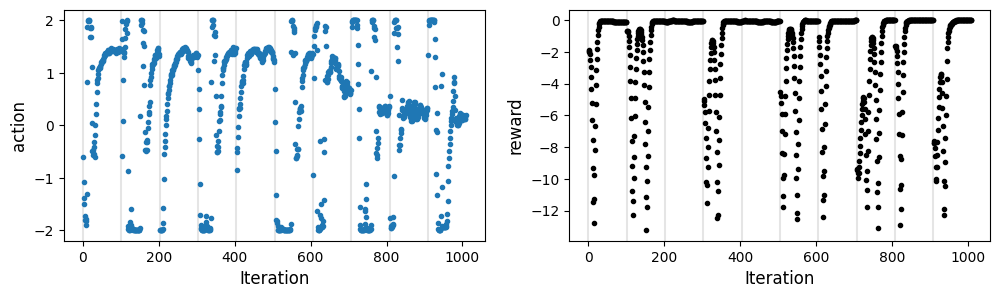

Episode 4:  -256.3269566584969
---------


In [21]:
#train with mini-batches and plotting for 10 episodes
max_episodes = 5
episode_rewards, env = mini_batch_train(env, agent, max_episodes, max_steps, batch_size)

#### Question: how does the agent performance look early in training? What would you expect to see?
Now continue trainining without plotting (plotting slows down execution)

In [14]:
#faster training without plotting for 50 more episodes
env.plot = False
max_episodes = 50
episode_rewards, env = mini_batch_train(env, agent, max_episodes, max_steps, batch_size)

Episode 49:  -239.14402815578663
---------


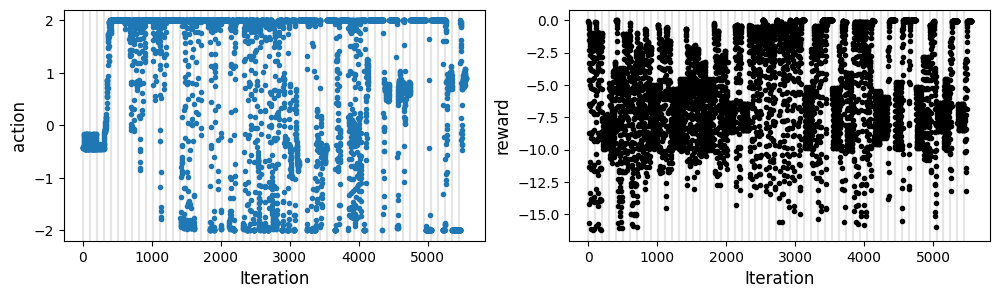

In [15]:
#plot the results of that previous training
env.plot_results()

#### Question: how does the agent performance look as training progresses? What would you expect to see?
Now examine the agent's behavior at present for 5 episodes below

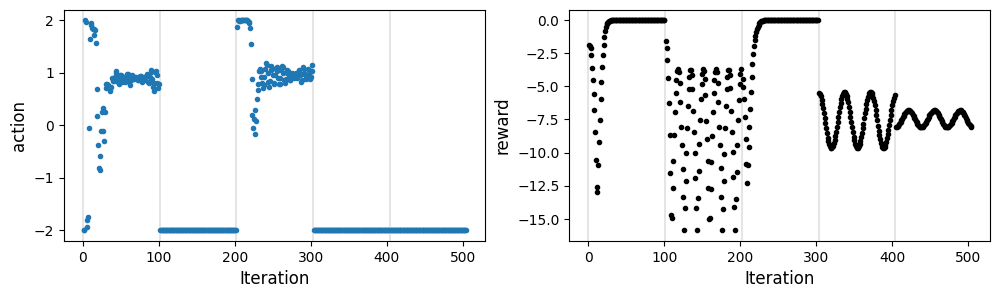

Episode 4:  -745.5001844295797
---------


In [16]:
#rest plot and see how training is going with live plotting
env.reset_plot()
env.plot = True
max_episodes = 5
episode_rewards, env = mini_batch_train(env, agent, max_episodes, max_steps, batch_size)

In [17]:
#continue training
env.plot = False
max_episodes = 90
episode_rewards, env = mini_batch_train(env, agent, max_episodes, max_steps, batch_size)

Episode 89:  -386.1508394655146
---------


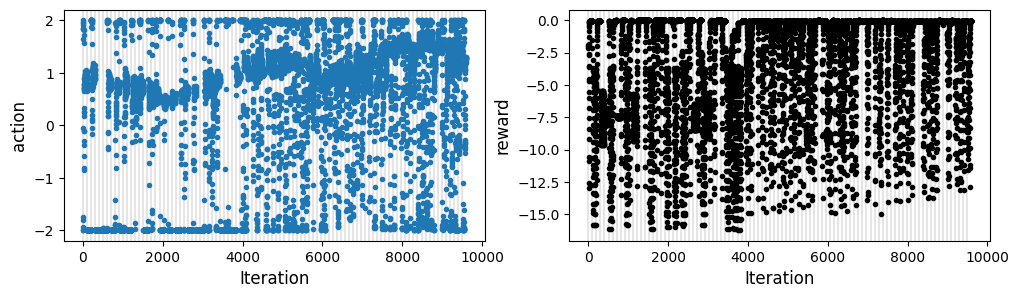

In [18]:
env.plot_results()

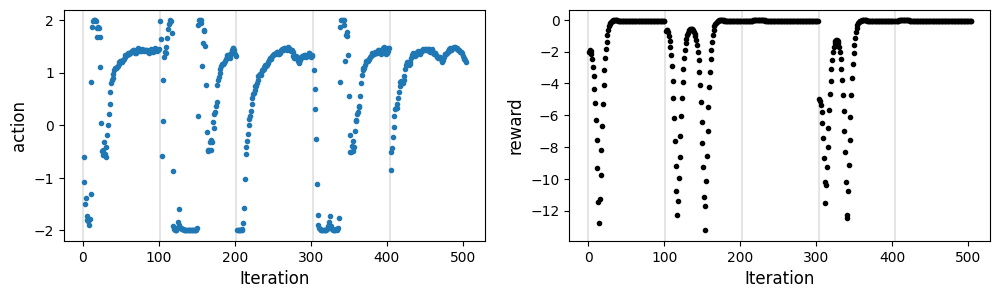

Episode 4:  -6.747380689626401
---------


In [19]:
#rest plot and see how training is going with live plotting
env.reset_plot()
env.plot = True
max_episodes = 5
episode_rewards, env = mini_batch_train(env, agent, max_episodes, max_steps, batch_size)

#### Question: how does the agent performance look after a lot of training?
 How do the actions it takes and the reward obtained in each episode compare to early on in training?


<a id='beamsize'></a>

#### Question: based on your observations, please comment on what the pros and cons of using RL for online accelerator tuning might be, compared to other approaches we have studied in the class?